<a href="https://colab.research.google.com/github/lorenafc/MscThesis_EyeTrackingIVR/blob/main/autoencoder_with_rf_thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting Fixations in Eye tracking Data in Immersive Virtual Environments using Autoencoder + Random Forest

I am adapting the autoencoder + Random Forest from this original work:


" Autoencoder (MNIST) + Scikit-Learn Random Forest Classifier

A simple, single-hidden-layer, fully-connected autoencoder that compresses 768-pixel MNIST images into 32-pixel vectors (32-times smaller representations). A random forest classifier is then trained for predicting the class labels based on that 32-pixel compressed space.


Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.

Author: Sebastian Raschka
GitHub Repository: https://github.com/rasbt/deeplearning-models
https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/autoencoder/ae-basic-with-rf.ipynb "


CPython 3.7.3, IPython 7.9.0, torch 1.3.0


Generative AI is being used to help writting the script and debugging

- Runs on CPU or GPU (if available)

## Imports

In [74]:
import time
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True


In [75]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

Device: cpu


In [76]:
file_name = '/content/eye_tracking_data_small_2019.csv'

# Read the Excel file
eye_tracking_data_small_2019 = pd.read_csv(file_name)


In [77]:
eye_tracking_data_small_2019.head(3)

,time,L_x,L_y,L_z,C_x,C_y,C_z,observer,GT1,GT2,GT3,GT4,GT5,GT6,GT7
0,9.314,-2.969,1.6232,-1.2434,-0.4009,1.6289,-1.2939,1,0,0,0,0,0,0,0
1,9.337,-2.969,1.6255,-1.2432,-0.4007,1.6290,-1.2940,1,0,0,0,0,0,0,0
2,9.360,-2.969,1.6260,-1.2447,-0.4006,1.6290,-1.2940,1,0,0,0,0,0,0,0


## Data cleaning

In [78]:
eye_tracking_data_small_2019 = eye_tracking_data_small_2019.drop(columns=["observer",'GT2', 'GT3', 'GT4', 'GT5', 'GT6', 'GT7'])  # Use only non-GT columns as features. Removing the labels
# Reorder DataFrame columns
eye_tracking_data_small_2019 = eye_tracking_data_small_2019[['time', 'L_x', 'L_y', 'L_z',"C_x", "C_y", "C_z", "GT1" ]]
print(eye_tracking_data_small_2019.head(2))

    time    L_x     L_y     L_z     C_x     C_y     C_z  GT1
0  9.314 -2.969  1.6232 -1.2434 -0.4009  1.6289 -1.2939    0
1  9.337 -2.969  1.6255 -1.2432 -0.4007  1.6290 -1.2940    0


In [79]:
# Convert all columns to float32 for compatibility with PyTorch
eye_tracking_data_small_2019 = eye_tracking_data_small_2019.astype('float32')


In [80]:
#with GT1 (using ground truth 1 as the label, which indicates fixation or no fixation)
et_train_with_GT1 = eye_tracking_data_small_2019.iloc[:1536, :]
et_test_with_GT1 = eye_tracking_data_small_2019.iloc[1536:, :]

from sklearn.preprocessing import MinMaxScaler #Transform features by scaling each feature to a given range, used to Train the model.
scaler = MinMaxScaler()
et_train_with_GT1 = pd.DataFrame(scaler.fit_transform(et_train_with_GT1), columns=et_train_with_GT1.columns)
et_test_with_GT1 = pd.DataFrame(scaler.transform(et_test_with_GT1), columns=et_test_with_GT1.columns)

## Model

In [81]:
##########################
### SETTINGS
##########################

# Hyperparameters
random_seed = 123
learning_rate = 0.005
num_epochs = 5
batch_size = 256

# Architecture
num_features = 7 # number of features
num_hidden_1 = 3 # number chosen

In [82]:
##########################
### MODEL
##########################

class Autoencoder(torch.nn.Module):

    def __init__(self, num_features):
        super(Autoencoder, self).__init__()

        ### ENCODER

        self.linear_1 = torch.nn.Linear(num_features, num_hidden_1)
        # The following to lones are not necessary,
        # but used here to demonstrate how to access the weights
        # and use a different weight initialization.
        # By default, PyTorch uses Xavier/Glorot initialization, which
        # should usually be preferred.
        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()

        ### DECODER
        self.linear_2 = torch.nn.Linear(num_hidden_1, num_features)
        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()

    def encoder(self, x):
        encoded = self.linear_1(x)
        encoded = F.leaky_relu(encoded)
        return encoded

    def decoder(self, encoded_x):
        logits = self.linear_2(encoded_x)
        decoded = torch.sigmoid(logits)
        return decoded


    def forward(self, x):

        ### ENCODER
        encoded = self.encoder(x)

        ### DECODER
        decoded = self.decoder(encoded)

        return decoded


torch.manual_seed(random_seed)
model = Autoencoder(num_features=num_features)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Transform to tensor

In [48]:

# #transform to tensor
# import torch
# from torch.utils.data import Dataset, DataLoader

# class EyeTrackingDataset(Dataset): # The class that Returns features and label does not work to train the data
#     def __init__(self, df):
#         # Convert DataFrame to a tensor and ensure dtype is float
#         self.data = torch.tensor(df.values, dtype=torch.float32)

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         return self.data[idx]


# #Initialize Dataset and DataLoader
# train_dataset = EyeTrackingDataset(et_train)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)


# test_dataset = EyeTrackingDataset(et_test)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)


In [83]:

class EyeTrackingDataset(Dataset):
    def __init__(self, df, with_labels=True):
        self.with_labels = with_labels
        self.data = torch.tensor(df.drop(columns='GT1').values, dtype=torch.float32)  # Features only
        if with_labels:
            self.labels = torch.tensor(df['GT1'].values, dtype=torch.long)  # Labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.with_labels:
            return self.data[idx], self.labels[idx]  # Return features and label
        else:
            return self.data[idx]  # Return only features for autoencoder

In [84]:
# Dataset without labels for autoencoder
train_dataset = EyeTrackingDataset(et_train_with_GT1, with_labels=True)
test_dataset = EyeTrackingDataset(et_test_with_GT1, with_labels=True)

# DataLoaders for autoencoder
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

print(et_train_with_GT1.shape) # 8 columns because GT1 is included
print(et_test_with_GT1.shape)

(1536, 8)
(483, 8)


In [85]:
#Training: FEATURES AND TARGETS

start_time = time.time()
for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):

        # don't need labels, only the images (features)
        features = features.to(device)

        ### FORWARD AND BACK PROP
        decoded = model(features)
        cost = F.binary_cross_entropy(decoded, features)
        optimizer.zero_grad()

        cost.backward()

        ### UPDATE MODEL PARAMETERS
        optimizer.step()

        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f'
                   %(epoch+1, num_epochs, batch_idx,
                     len(train_loader), cost))

    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/005 | Batch 000/006 | Cost: 0.7187
Time elapsed: 0.00 min
Epoch: 002/005 | Batch 000/006 | Cost: 0.7016
Time elapsed: 0.01 min
Epoch: 003/005 | Batch 000/006 | Cost: 0.6885
Time elapsed: 0.01 min
Epoch: 004/005 | Batch 000/006 | Cost: 0.6750
Time elapsed: 0.01 min
Epoch: 005/005 | Batch 000/006 | Cost: 0.6611
Time elapsed: 0.01 min
Total Training Time: 0.01 min


## Training

In [65]:
print(features.shape)


torch.Size([256, 7])


## Evaluation

### Training Dataset

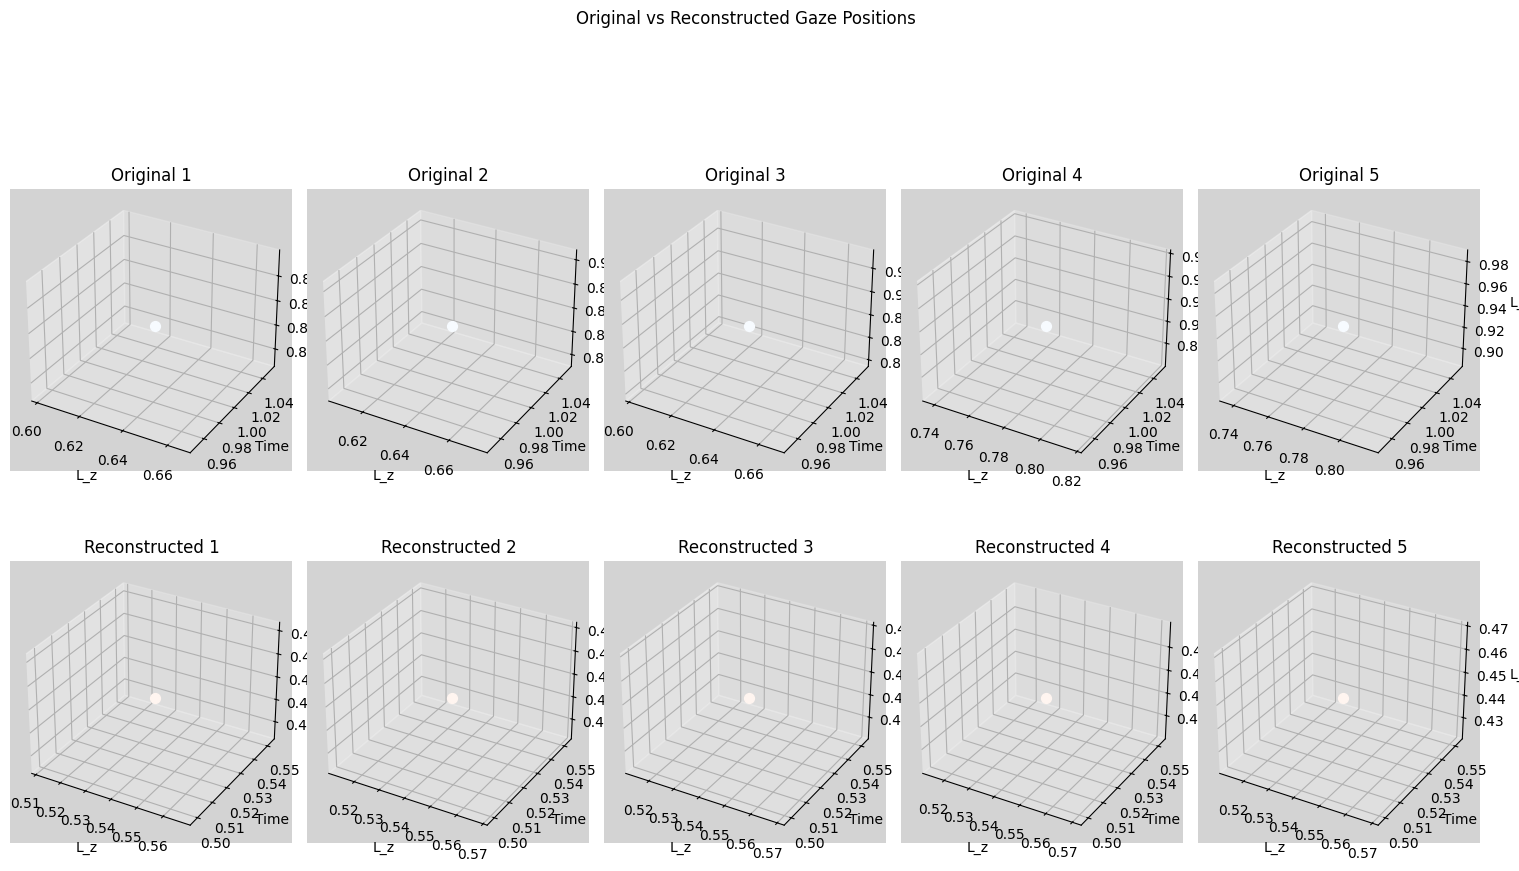

In [86]:
#chat gpt - Eye Tracking

import matplotlib.pyplot as plt
import torch

# Setting the interval and sample size for better visualization
interval = 40  # Interval of 40 rows to get better variations in data
n_samples = 5  # Number of samples to visualize

# Ensure to sample with the interval for distinct visualization points
original_data = features[::interval][:n_samples, [1, 2, 0]].cpu().detach().numpy()  # L_y, L_z, and time
reconstructed_data = decoded[::interval][:n_samples, [1, 2, 0]].cpu().detach().numpy()  # L_y, L_z, and time

# Creating the 3D plot with L_y (vertical), L_z (horizontal), and time as depth with improved background
fig = plt.figure(figsize=(15, 10))
fig.suptitle("Original vs Reconstructed Gaze Positions")

# Loop through each sample and plot
for i in range(n_samples):
    ax = fig.add_subplot(2, n_samples, i + 1, projection='3d')
    # Original data in blue with clear background
    ax.scatter(original_data[i, 1], original_data[i, 0], original_data[i, 2],
               c=original_data[i, 2], cmap='Blues', s=50, label="Original", depthshade=False)
    ax.set_title(f"Original {i+1}")
    ax.set_xlabel("L_z")
    ax.set_ylabel("Time")
    ax.set_zlabel("L_y")
    ax.set_facecolor("lightgrey")  # Set background for visibility

    ax = fig.add_subplot(2, n_samples, n_samples + i + 1, projection='3d')
    # Reconstructed data in red with clear background
    ax.scatter(reconstructed_data[i, 1], reconstructed_data[i, 0], reconstructed_data[i, 2],
               c=reconstructed_data[i, 2], cmap='Reds', s=50, label="Reconstructed", depthshade=True)
    ax.set_title(f"Reconstructed {i+1}")
    ax.set_xlabel("L_z")
    ax.set_ylabel("Time")
    ax.set_zlabel("L_y")
    ax.set_facecolor("lightgrey")  # Set background for visibility

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Scikit-learn Classifier

## RF with no features from autoencoder

In [87]:
et_rf = eye_tracking_data_small_2019.copy() # all rows of the dataset with GT1
print(et_rf.shape)
print(et_rf.columns)

(2019, 8)
Index(['time', 'L_x', 'L_y', 'L_z', 'C_x', 'C_y', 'C_z', 'GT1'], dtype='object')


In [88]:
feature_cols = ['time', 'L_x', 'L_y', 'L_z', 'C_x', 'C_y', 'C_z']
X = et_rf[feature_cols] # Features
y = et_rf.GT1 # Target variable
print(f"X:{X.shape} y:{y.shape}")

X:(2019, 7) y:(2019,)


In [89]:
#### I tested with both splitting of training data and TimeSeriesSplit performed better


##### 1st attempt: TimeSeriesSplit ##########

from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(
    n_splits=2,
    gap=0,
    max_train_size=1536,

)

all_splits = list(tss.split(X, y))

train_idx, test_idx = all_splits[0]
X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


# Train Accuracy: 99.70282317979198%
# Test Accuracy: 71.91679049034175%

########## 2nd attempt: manually split ##########


# Manually select training and testing indices
# train_end = 1536  # Define the last index for the training set

# # Define training and test sets based on your specified index
# X_train, X_test = X.iloc[:train_end, :], X.iloc[train_end:, :]
# y_train, y_test = y.iloc[:train_end], y.iloc[train_end:]

## Train Accuracy: 96.09375%
##Test Accuracy: 32.71221532091098%




# print(all_splits) # It is splitted in 3 arrays.
#Is it because of this change? -> "Changed in version 0.22: n_splits default value changed from 3 to 5." https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.TimeSeriesSplit.html

In [90]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
n_estimators = 50, max_depth=8, oob_score=True
)

rf.fit(X_train, y_train)
print(f'Train Accuracy: {rf.score(X_train, y_train)*100}%')
print(f'Test Accuracy: {rf.score(X_test, y_test)*100}%')

Train Accuracy: 100.0%
Test Accuracy: 89.74739970282319%


In [91]:
print("R^2",rf.oob_score_)

R^2 0.9777117384843982


## Using autoencoder extracted features

### Using Autoencoder - Approach 1-  kept "labels" in the for loop, like in the MNIST dataset

In [93]:
# Dataset without labels for autoencoder
train_dataset_ae = EyeTrackingDataset(et_train_with_GT1, with_labels=True) # kept with_labels = True to use the labels in the for loop    6/11 15:53 - adding et_train_with_GT1
test_dataset_ae = EyeTrackingDataset(et_test_with_GT1, with_labels=True) # et-train and et_test keeps GT1 column

print(et_train_with_GT1.shape)
print(et_test_with_GT1.shape)

# DataLoaders for autoencoder
train_loader_ae = DataLoader(train_dataset_ae, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_ae = DataLoader(test_dataset_ae, batch_size=batch_size, shuffle=False, drop_last=True)


(1536, 8)
(483, 8)


In [94]:
X_train_ae = np.ones((1536, num_hidden_1))
y_train_ae = np.ones(1536) # Target variable

# y_train_no_ae = y.copy()
# y_train_no_ae = y_train_no_ae[:1536].to_numpy()

print(f"X_train_ae:{X_train_ae.shape} y_train_ae:{y_train_ae.shape})" )

X_train_ae:(1536, 3) y_train_ae:(1536,))


In [95]:

start_idx = 0

for idx, (gaze_data, labels) in enumerate(train_loader_ae): #kept labels like the other code
    features = gaze_data.view(gaze_data.size(0), -1).to(device)
    decoded = model.encoder(features)

    batch_size = decoded.shape[0]
    X_train_ae[start_idx:start_idx+batch_size] = decoded.to(torch.device('cpu')).detach().numpy()
    y_train_ae[start_idx:start_idx+batch_size] = labels
    start_idx += batch_size

X_test_ae = np.ones((256, num_hidden_1)) # the remaining samples for the test would be 483, but chose a size of power of 2
y_test_ae = np.ones(256)

start_idx = 0

for idx, (gaze_data, labels) in enumerate(test_loader_ae):

        features = gaze_data.view(gaze_data.size(0), -1).to(device)
        decoded = model.encoder(features)

        batch_size = decoded.shape[0]
        X_test_ae[start_idx:start_idx + batch_size] = decoded.to(torch.device('cpu')).detach().numpy()
        y_test_ae[start_idx:start_idx+batch_size] = labels.cpu().numpy()
        start_idx += batch_size




In [96]:
rf = RandomForestClassifier(
n_estimators = 50, max_depth=8, oob_score=True
)
rf = RandomForestClassifier(n_estimators=500, n_jobs=-1).fit(X_train_ae, y_train_ae) #  n_jobs =-1 means using all processors.

print(f'Train Accuracy: {rf.score(X_train_ae, y_train_ae)*100}%')
print(f'Test Accuracy: {rf.score(X_test_ae, y_test_ae)*100}%')

Train Accuracy: 100.0%
Test Accuracy: 37.109375%


### Using Autoencoder - Approach 2 - Removing "labels" from the for loop:

In [97]:
# Dataset without labels for autoencoder
train_dataset = EyeTrackingDataset(et_train_with_GT1, with_labels=False)
test_dataset = EyeTrackingDataset(et_test_with_GT1, with_labels=False)

# DataLoaders for autoencoder
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

print(et_train_with_GT1.shape) # 8 columns because GT1 is included
print(et_test_with_GT1.shape)

(1536, 8)
(483, 8)


In [98]:
print(train_dataset)
print(train_loader)

In [99]:
feature_cols = ['time', 'L_x', 'L_y', 'L_z', 'C_x', 'C_y', 'C_z']
# X = et_rf[feature_cols] # Features
y = et_rf.GT1 # Target variable
print(f" y:{y.shape}")


 y:(2019,)


In [100]:
y_train_no_label = y.copy()
y_train_no_label = y_train_no_label[:1536]#.to_numpy()

y_test_no_label = y.copy()
y_test_no_label = y_test_no_label[1536:1792]#.tonumpy()

print(f"y_train_no_label:{y_train_no_label.shape}, y_test_no_label:{y_test_no_label.shape}" )

y_train_no_label:(1536,), y_test_no_label:(256,)


In [101]:
X_train_no_label = np.ones((1536, num_hidden_1))
# y_train_no_label = np.ones(1536)

start_idx = 0

for idx, gaze_data in enumerate(train_loader):
    features = gaze_data.view(gaze_data.size(0), -1).to(device)
    decoded = model.encoder(features)

    batch_size = decoded.shape[0]
    X_train_no_label[start_idx:start_idx+batch_size] = decoded.to(torch.device('cpu')).detach().numpy()
    #y_train_ae[start_idx:start_idx+10] = labels
    start_idx += batch_size

X_test_no_label = np.ones((256, num_hidden_1))
#y_test_ae = np.ones(256)

start_idx = 0

for idx, gaze_data in enumerate(test_loader):
    features = gaze_data.view(gaze_data.size(0), -1).to(device)
    decoded = model.encoder(features)

    batch_size = decoded.shape[0]
    X_test_no_label[start_idx:start_idx + batch_size] = decoded.to(torch.device('cpu')).detach().numpy()
    #y_test[start_idx:start_idx+10] = labels
    start_idx += batch_size

In [102]:
rf = RandomForestClassifier(
n_estimators = 50, max_depth=8, oob_score=True
)
rf = RandomForestClassifier(n_estimators=500, n_jobs=-1).fit(X_train_no_label, y_train_no_label) #  n_jobs =-1 means using all processors.

print(f'Train Accuracy: {rf.score(X_train_ae, y_train_no_label)*100}%')
print(f'Test Accuracy: {round(rf.score(X_test_ae, y_test_no_label)*100,2)}%')

Train Accuracy: 100.0%
Test Accuracy: 37.11%
